<a href="https://colab.research.google.com/github/AkshitAggarwal/Time_Series_Forecasting_Hopitalisations/blob/main/Covid_Hospitalizations_Minor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
dataset = pd.read_csv("Data_Minor_test.csv",parse_dates=True)
dataset.index.freq='DS'

In [ ]:
dataset.head()

,Date,Beds Occupied
0,16-07-2020,38532
1,17-07-2020,40057
2,18-07-2020,40372
3,19-07-2020,37895
4,20-07-2020,41136


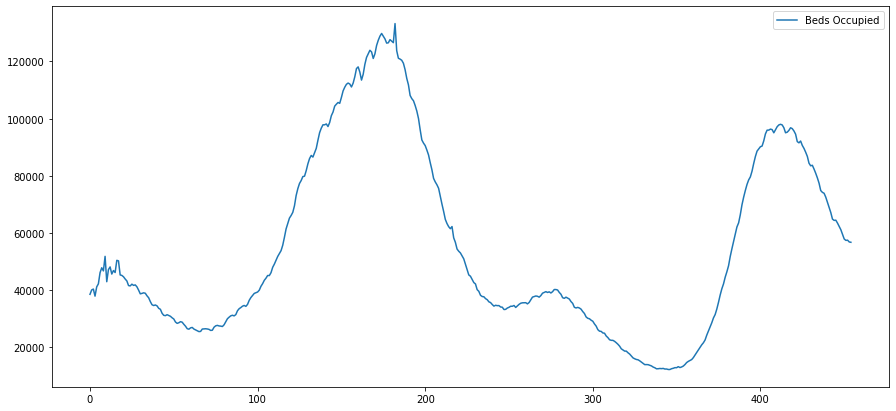

In [ ]:
dataset.plot(figsize=(15,7))

In [ ]:
len(dataset)

455